### Import Statements

In [19]:
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import utils
# Scikit-Learn for Modeling
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from matplotlib import pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.helper_functions import rmspe
from scripts.load_data import PostgresDBUtils

from datetime import datetime, timedelta
from joblib import dump
import itertools
import numpy as np
import seaborn as sns

In [20]:
df = pd.read_csv('../data/clean_data.csv')

In [21]:
df.head()

,campaign_id,campaign_name,submission_date,description,campaign_objectives,kpis,placements,start_date,end_date,serving_locations,...,volume_agreed,gross_cost,agency_fee,percentage,net_cost,click-through-event,first_dropped,impression,engagement_rate,click_through_rate
0,12dc55z,Fox 9-1-1 S4 Premiere | Sensory Video | AV,19/12/2019 17:38,Hey @alicia below are the details for the upco...,Brand Awareness,Engagement Rate,320x480 (Fullscreen mobile / interstitial),13/01/2020,20/12/2019,US,...,0.00,0.00,Percentage,15.0,0.00,660,1196,8144,0.146857,0.551839
1,22yeess,Lionsgate Spiral Movie | Sensory Engagement | ...,21/04/2021 16:54,Hello Design Team - Below is the info for the ...,Brand Awareness\nAudience Engagement,VTR\nCTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),30/04/2021,16/05/2021,US National,...,151515.15,50000.00,Percentage,0.0,50000.00,98,567,9335,0.060739,0.172840
2,2z6pk1p,VCA_FRIVOLE WAVE 2_2021_SG - CPE Algo,15/12/2020 23:57,Storyboard Stage : \r\nThe storyboards are cur...,Brand Awareness\nProduct Awareness\nMessage Re...,Engagement Rate,320x480 (Fullscreen mobile / interstitial)\n30...,11/01/2021,31/01/2021,Singapore,...,40336.00,25411.68,Percentage,15.0,21599.93,99,904,8997,0.100478,0.109513
3,3ej4hd8,Ad Sequence - Sensory | CPE | P1B7VZ3 - CPE Algo,22/04/2020 11:25,Hey Kentaro - below is the latest live campaig...,Brand Awareness\nProduct Awareness\nConsiderat...,CTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),04/05/2020,31/08/2020,USA,...,5963333.33,1789000.00,Percentage,0.0,1789000.00,0,6,15,0.400000,0.000000
4,5qtwg2a,Lexus East | Philadelphia | Sensory Video | C...,05/10/2020 12:50,Hey team see details for the campaign below: \...,Brand Awareness,CTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),12/10/2020,31/12/2020,USA,...,0.00,0.00,Percentage,15.0,0.00,1116,1369,7515,0.182169,0.815194


In [22]:
# convert submission_date to year, month, day, hour and minute
df['submission_date'] = pd.to_datetime(df['submission_date'])
df['submission_date_year'] = df['submission_date'].dt.year
df['submission_date_month'] = df['submission_date'].dt.month
df['submission_date_date'] = df['submission_date'].dt.day
df['submission_date_hour'] = df['submission_date'].dt.hour
df['submission_date_minute'] = df['submission_date'].dt.minute
df = df.drop(['submission_date'], axis=1)

In [23]:
# convert start_date to year, month, day, hour and minute
df['start_date'] = pd.to_datetime(df['start_date'], infer_datetime_format=True)
df['start_date_year'] = df['start_date'].dt.year
df['start_date_month'] = df['start_date'].dt.month
df['start_date_date'] = df['start_date'].dt.day
df = df.drop(['start_date'], axis=1)

In [24]:
# convert end_date to year, month, day, hour and minute
df['end_date'] = pd.to_datetime(df['end_date'], infer_datetime_format=True)
df['end_date_year'] = df['end_date'].dt.year
df['end_date_month'] = df['end_date'].dt.month
df['end_date_date'] = df['end_date'].dt.day
df = df.drop(['end_date'], axis=1)

In [37]:
df

,campaign_id,campaign_name,description,campaign_objectives,kpis,placements,serving_locations,black_white_audience_list_included,cost_centre,currency,...,submission_date_month,submission_date_date,submission_date_hour,submission_date_minute,start_date_year,start_date_month,start_date_date,end_date_year,end_date_month,end_date_date
0,12dc55z,Fox 9-1-1 S4 Premiere | Sensory Video | AV,Hey @alicia below are the details for the upco...,Brand Awareness,Engagement Rate,320x480 (Fullscreen mobile / interstitial),US,0,USA,USD,...,12,19,17,38,2020,1,13,2019,12,20
1,22yeess,Lionsgate Spiral Movie | Sensory Engagement | ...,Hello Design Team - Below is the info for the ...,Brand Awareness\nAudience Engagement,VTR\nCTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),US National,1,USA,USD,...,4,21,16,54,2021,4,30,2021,5,16
2,2z6pk1p,VCA_FRIVOLE WAVE 2_2021_SG - CPE Algo,Storyboard Stage : \r\nThe storyboards are cur...,Brand Awareness\nProduct Awareness\nMessage Re...,Engagement Rate,320x480 (Fullscreen mobile / interstitial)\n30...,Singapore,0,SGP,SGD,...,12,15,23,57,2021,1,11,2021,1,31
3,3ej4hd8,Ad Sequence - Sensory | CPE | P1B7VZ3 - CPE Algo,Hey Kentaro - below is the latest live campaig...,Brand Awareness\nProduct Awareness\nConsiderat...,CTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),USA,1,USA,USD,...,4,22,11,25,2020,5,4,2020,8,31
4,5qtwg2a,Lexus East | Philadelphia | Sensory Video | C...,Hey team see details for the campaign below: \...,Brand Awareness,CTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),USA,1,USA,USD,...,5,10,12,50,2020,10,12,2020,12,31
5,73y46dg,BIO Sequence - Sensory | CPE | P1B7VZ3,Hey Kentaro - below is the latest live campaig...,Brand Awareness\nProduct Awareness\nConsiderat...,CTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),USA,1,USA,USD,...,4,22,11,25,2020,5,4,2020,8,31
6,758ifo0,Lexus East | Philadelphia | Sensory Video | C...,Hey team see details for the campaign below: \...,Brand Awareness,CTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),USA,1,USA,USD,...,5,10,12,50,2020,10,12,2020,12,31
7,8muucqy,Lexus East | Boston | Sensory Video | CPE AV,Hey Kentaro - Below is the info for the Lexus ...,Brand Awareness,CTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),"NY, Boston, Philadelphia",1,USA,USD,...,2,14,14,48,2020,3,1,2020,11,30
8,93abu9r,Lionsgate Hitman's Wife's Bodyguard | Sensory ...,Hi Design - We've received approval on the the...,Brand Awareness\nDrive Traffic (to site)\nAudi...,CTR\nEngagement Rate,320x480 (Fullscreen mobile / interstitial),US National,1,USA,GBP,...,12,5,18,54,2021,5,22,2021,6,20
9,b3sw44m,AUDI_E TRON_2021_01_SG,**DESIGN SECTION**\r\n\r\nStoryboard Stage : \...,Brand Awareness\nProduct Awareness\nMessage Re...,Engagement Rate,320x480 (Fullscreen mobile / interstitial)\n30...,Singapore,1,SGP,SGD,...,12,22,6,24,2021,1,8,2021,2,18


In [26]:
data = df.drop(['campaign_id', 'campaign_name', 'description', 'campaign_objectives', 'kpis', 'placements', 'serving_locations', 'cost_centre', 'currency', 'agency_fee', 'percentage'], axis=1)

In [27]:
data

,black_white_audience_list_included,buy_rate,volume_agreed,gross_cost,net_cost,click-through-event,first_dropped,impression,engagement_rate,click_through_rate,...,submission_date_month,submission_date_date,submission_date_hour,submission_date_minute,start_date_year,start_date_month,start_date_date,end_date_year,end_date_month,end_date_date
0,0,0.30,0.00,0.00,0.00,660,1196,8144,0.146857,0.551839,...,12,19,17,38,2020,1,13,2019,12,20
1,1,0.33,151515.15,50000.00,50000.00,98,567,9335,0.060739,0.172840,...,4,21,16,54,2021,4,30,2021,5,16
2,0,0.63,40336.00,25411.68,21599.93,99,904,8997,0.100478,0.109513,...,12,15,23,57,2021,1,11,2021,1,31
3,1,0.30,5963333.33,1789000.00,1789000.00,0,6,15,0.400000,0.000000,...,4,22,11,25,2020,5,4,2020,8,31
4,1,0.40,0.00,0.00,0.00,1116,1369,7515,0.182169,0.815194,...,5,10,12,50,2020,10,12,2020,12,31
5,1,0.30,5963333.33,1789000.00,1789000.00,0,0,58,0.000000,NaN,...,4,22,11,25,2020,5,4,2020,8,31
6,1,0.40,0.00,0.00,0.00,850,1112,8038,0.138343,0.764388,...,5,10,12,50,2020,10,12,2020,12,31
7,1,0.40,531179.00,212471.60,212471.60,851,1256,7893,0.159128,0.677548,...,2,14,14,48,2020,3,1,2020,11,30
8,1,0.35,214285.71,75000.00,75000.00,198,1667,8126,0.205144,0.118776,...,12,5,18,54,2021,5,22,2021,6,20
9,1,0.49,64826.00,31764.74,27000.03,48,348,9604,0.036235,0.137931,...,12,22,6,24,2021,1,8,2021,2,18


In [28]:
# X = data[['black_white_audience_list_included', 'buy_rate', 'volume_agreed' ,'gross_cost', 'percentage', 'net_cost', 'click-through-event', 'first_dropped', 'impression', 'submission_date_year', 'submission_date_month', 'submission_date_date', 'submission_date_hour', 'submission_date_minute', 'start_date_year', 'start_date_month', 'start_date_date', 'end_date_year', 'end_date_month', 'end_date_date']]
# y = data['engagement_rate']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
X = data[['black_white_audience_list_included', 'buy_rate', 'volume_agreed' ,'gross_cost', 'net_cost', 'click-through-event', 'first_dropped', 'impression']]
y = data['engagement_rate']
X_train, X_train_test, y_train, y_train_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=15)
print ("Training and testing split was successful.")

Training and testing split was successful.


## Random Forest Regressor

In [30]:
rfr = RandomForestRegressor(n_estimators=10,
                            criterion='mse',
                            max_depth=5,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=4,
                            random_state=31,
                            verbose=0,
                            warm_start=False)
rfr.fit(X_train, y_train)

/Users/diyemark/PycharmProjects/AdludioDataScienceChallenge/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/diyemark/PycharmProjects/AdludioDataScienceChallenge/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(criterion='mse', max_depth=5, max_features='auto',
                      n_estimators=10, n_jobs=4, random_state=31)

### Test our RF on the validation set

In [31]:
rfr_val=RandomForestRegressor(n_estimators=128,
                             criterion='mse',
                             max_depth=20,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=4,
                             random_state=35,
                             verbose=0,
                             warm_start=False)
model_RF_test=rfr_val.fit(X_train,y_train)

/Users/diyemark/PycharmProjects/AdludioDataScienceChallenge/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/diyemark/PycharmProjects/AdludioDataScienceChallenge/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [32]:
yhat=model_RF_test.predict(X_train_test)

(array([5., 0., 0., 2., 0., 0., 1., 0., 0., 3.]),
 array([0.0065176 , 0.02623225, 0.0459469 , 0.06566155, 0.0853762 ,
        0.10509085, 0.12480551, 0.14452016, 0.16423481, 0.18394946,
        0.20366411]),
 <BarContainer object of 10 artists>)

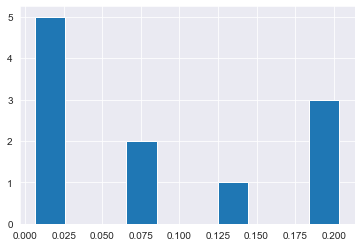

In [33]:
plt.hist(yhat)

In [34]:
error=rmspe(y_train_test,yhat)
error

0.11910511394917311

#### Export Model

In [35]:
model_timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
dump(filename=f'../models/{model_timestamp}.pkl', value=rfr, compress=9)

['../models/2022-08-10-15-12-20.pkl']

#### Feature Importance

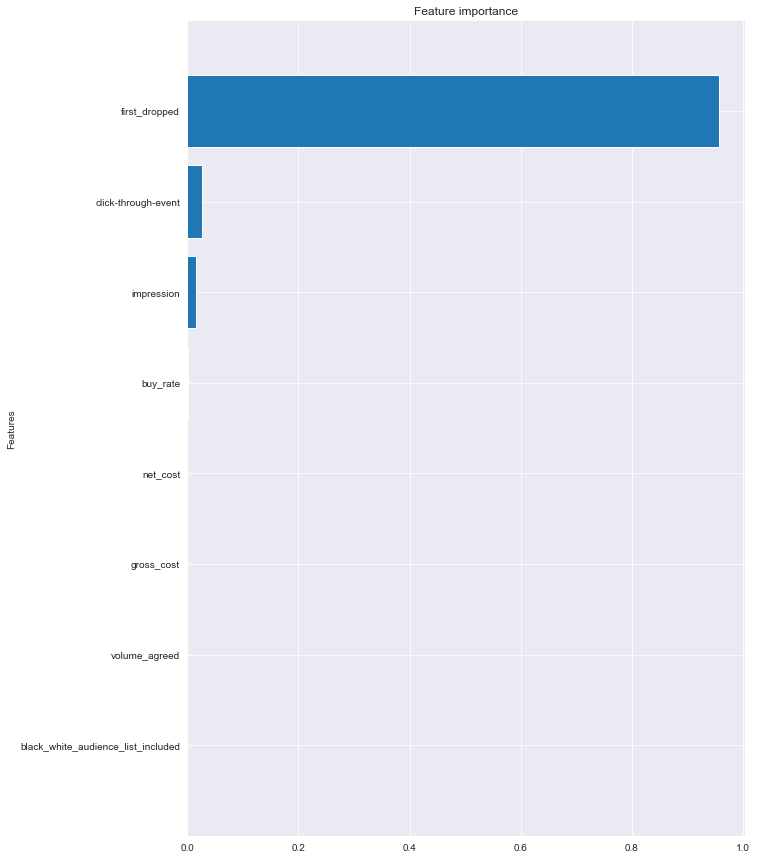

In [36]:
importance = rfr_val.feature_importances_
std = np.std([rfr_val.feature_importances_ for tree in rfr_val.estimators_],
             axis=0)
indices = np.argsort(importance)
palette1 = itertools.cycle(sns.color_palette())
# Store the feature ranking
features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
# Plot the feature importances of the forest

plt.figure(figsize=(10,15))
plt.title("Feature importance")
plt.barh(range(X_train.shape[1]), importance[indices],
            color=[next(palette1)], align="center")
plt.yticks(range(X_train.shape[1]), features_ranked)
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]])
plt.show()